# Gerekli kütüphaneler

In [60]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_classif


# 1. Veri Setini Yükle ve Temizle

In [61]:
df = pd.read_csv("netflix_titles.csv")
df = df[df['rating'].isin(['TV-MA', 'TV-14', 'PG', 'R'])]
df = df[['type', 'rating', 'release_year', 'duration', 'country', 'listed_in', 'director', 'cast', 'description']].dropna()
df['duration'] = df['duration'].str.extract('(\d+)').astype(float)
df = df[df['duration'] < 500]  # outlier temizliği
df.reset_index(drop=True, inplace=True)

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Begum\AppData\Local\Temp\ipykernel_14648\11528546.py:4: SyntaxWarning: invalid escape sequence '\d'
  df['duration'] = df['duration'].str.extract('(\d+)').astype(float)


# 2. Görselleştirmeler

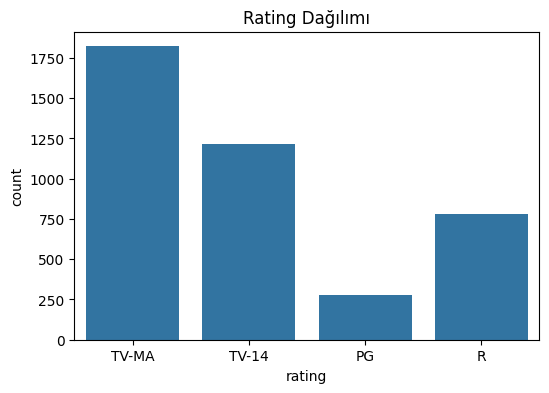

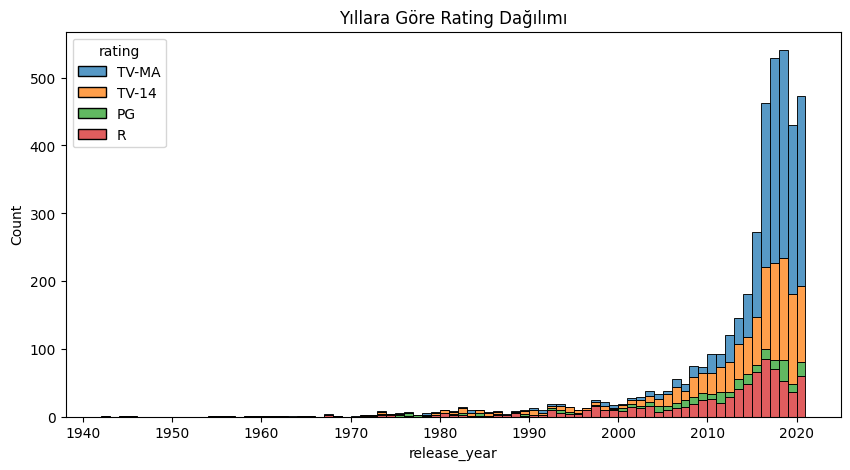

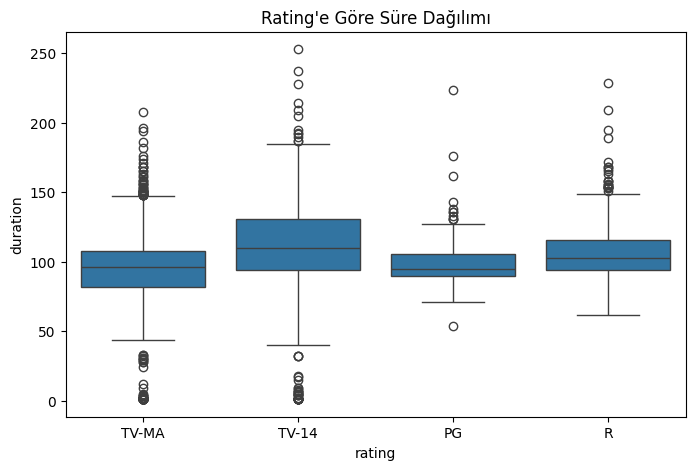

In [62]:
plt.figure(figsize=(6,4))
sns.countplot(x='rating', data=df)
plt.title('Rating Dağılımı')
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(data=df, x='release_year', hue='rating', multiple='stack', binwidth=1)
plt.title('Yıllara Göre Rating Dağılımı')
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x='rating', y='duration', data=df)
plt.title("Rating'e Göre Süre Dağılımı")
plt.show()

# 3. Özellik Mühendisliği
# Genre -> Çoklu etiket vektörü

In [63]:
mlb = MultiLabelBinarizer()
genres = df['listed_in'].apply(lambda x: [i.strip() for i in x.split(',')])
genres_encoded = pd.DataFrame(mlb.fit_transform(genres), columns=mlb.classes_)

# Kategorik sütunlar -> Sayısal

In [64]:
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])
df['country'] = le.fit_transform(df['country'])
df['director'] = le.fit_transform(df['director'])
df['cast'] = le.fit_transform(df['cast'])
df['rating'] = le.fit_transform(df['rating'])

# Açıklamalar -> TF-IDF

In [65]:
tfidf = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf.fit_transform(df['description'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# Tüm özellikleri birleştir

In [66]:
X = pd.concat([
    df[['type', 'release_year', 'duration', 'country', 'director', 'cast']].reset_index(drop=True),
    genres_encoded.reset_index(drop=True),
    tfidf_df.reset_index(drop=True)
], axis=1)
y = df['rating']

# 4. Özellik Seçimi (SelectKBest)

In [67]:
selector = SelectKBest(score_func=f_classif, k=50)
X_selected = selector.fit_transform(X, y)

# 4. Modelleme

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


# 5. Başarı Ölçütleri

In [69]:
print("Tüm veri doğruluğu:", accuracy_score(y, clf.predict(X_selected)))
print("%70-%30 test doğruluğu:", accuracy_score(y_test, y_pred))
print("5-Fold CV doğruluğu:", cross_val_score(clf, X_selected, y, cv=5).mean())

Tüm veri doğruluğu: 0.9131817070188311
%70-%30 test doğruluğu: 0.710676446617767
5-Fold CV doğruluğu: 0.6573677327451797


# Konfüzyon Matrisi ve Rapor

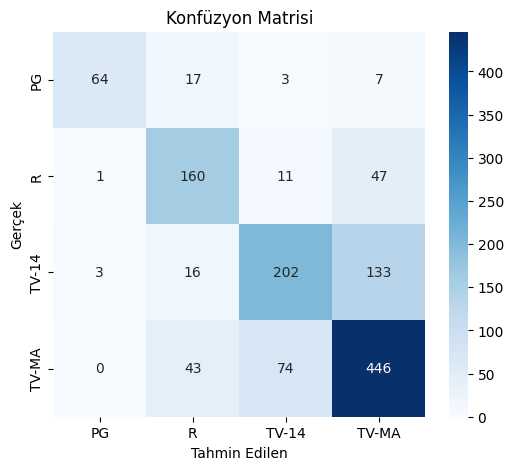

              precision    recall  f1-score   support

          PG       0.94      0.70      0.81        91
           R       0.68      0.73      0.70       219
       TV-14       0.70      0.57      0.63       354
       TV-MA       0.70      0.79      0.75       563

    accuracy                           0.71      1227
   macro avg       0.76      0.70      0.72      1227
weighted avg       0.72      0.71      0.71      1227



In [70]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Konfüzyon Matrisi')
plt.show()

print(classification_report(y_test, y_pred, target_names=le.classes_))

# 6. KMeans Kümeleme

In [71]:



kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(tfidf_matrix)

KMeans(n_clusters=5, random_state=42)

# Kümeleme sonuçlarını görselleştirelim

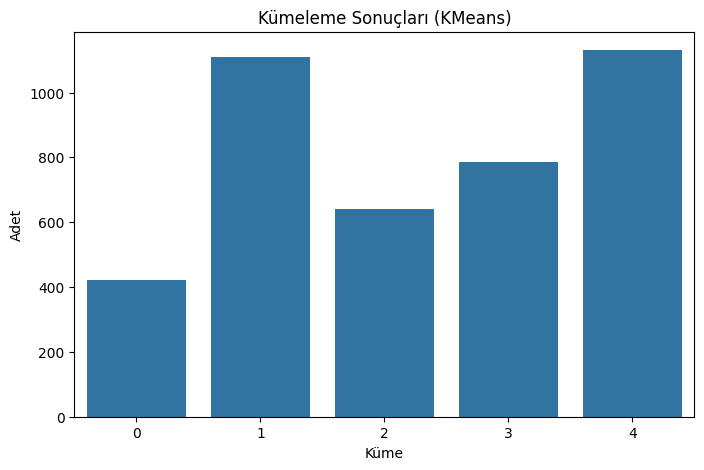

In [72]:
df['cluster'] = kmeans.labels_

plt.figure(figsize=(8,5))
sns.countplot(x='cluster', data=df)
plt.title('Kümeleme Sonuçları (KMeans)')
plt.xlabel('Küme')
plt.ylabel('Adet')
plt.show()